In [32]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [33]:
# import and clean the data

# chrome data
df_chrome = pd.read_csv("CB_chrome_cleaned.csv")
df_chrome = df_chrome.rename(columns={"visit_date" : "date", "visit_time": "time"})
df_chrome["date"] = pd.to_datetime(df_chrome["date"])
df_chrome = df_chrome.drop("Unnamed: 0", axis=1)

def get_first_and_last_visits(df):
    # find first and last visited websites per date
    first_visits = df.loc[df.groupby("date")["time"].idxmin()]
    last_visits = df.loc[df.groupby("date")["time"].idxmax()]

    # select relevant columns
    first_visits = first_visits[["date", "time", "url", "title"]].rename(columns={
        "time": "visit_time_first",
        "url": "url_first",
        "title": "title_first"
    })
    
    last_visits = last_visits[["date", "time", "url", "title"]].rename(columns={
        "time": "visit_time_last",
        "url": "url_last",
        "title": "title_last"
    })

    # merge both DataFrames on visit_date to get one row per date
    visit_summary = pd.merge(first_visits, last_visits, on="date")
    return visit_summary

df_chrome = get_first_and_last_visits(df_chrome)

# sleep data
df_sleep = pd.read_csv("cheryl_sleep_data.csv")
df_sleep = df_sleep.drop("Unnamed: 0", axis=1)
df_sleep = df_sleep.rename(columns={"Date": "date"})
df_sleep["date"] = pd.to_datetime(df_sleep["date"])
df_sleep["sleep_start"] = pd.to_datetime(df_sleep["sleep_start"])
df_sleep["sleep_end"] = pd.to_datetime(df_sleep["sleep_end"])
df_sleep["sleep_start_date"] = df_sleep["sleep_start"].dt.date
df_sleep["sleep_start_time"] = df_sleep["sleep_start"].dt.strftime("%H:%M:%S")
df_sleep["sleep_end date"] = df_sleep["sleep_end"].dt.date
df_sleep["sleep_end_time"] = df_sleep["sleep_end"].dt.strftime("%H:%M:%S")
df_sleep = df_sleep.drop(columns=["sleep_start", "sleep_end"])
df_sleep["date"] = df_sleep["sleep_start_date"]
df_sleep["date"] = pd.to_datetime(df_sleep["sleep_start_date"]) # made the date the sleep start date so you can compare visit_time_last with sleep start time, can compare sleep end time with visit_time_first of the next date

# merge the two dataframes
df = pd.merge(df_chrome, df_sleep, on="date", how="left")

# filter for time between jan 1 to feb 17
start_date = "2025-01-01"
end_date = "2025-02-17"
df = df[(df["date"] >= start_date) & (df["date"] <= end_date)]

df.head()

,date,visit_time_first,url_first,title_first,visit_time_last,url_last,title_last,total_sleep_hours,sleep_start_date,sleep_start_time,sleep_end date,sleep_end_time
34,2025-01-01,02:05:20,https://www.google.com/search?q=dsw&rlz=1C1ONG...,dsw - Google Search,22:56:56,https://www.amazon.com/s/ref=nb_sb_noss_2?url=...,Amazon.com : daisque,8.258333,2025-01-01,02:04:45,2025-01-01,10:30:15
35,2025-01-02,01:46:11,https://www.when2meet.com/?28134141-GcoK8,Club Figure Skating Spring 2024 Off Ice - When...,02:52:13,https://www.amazon.com/s?crid=1WQFLCYQMS1FY&i=...,Amazon.com : rice mask,11.283333,2025-01-02,01:25:02,2025-01-02,16:03:02
36,2025-01-03,01:56:00,https://www.amazon.com/s?crid=2ZM9BIE3J8XA8&i=...,Amazon.com : canmake,02:14:16,https://www.popflexactive.com/collections/perf...,Perfect Plane Pants - Black – POPFLEX®,7.325000,2025-01-03,02:04:16,2025-01-03,09:45:16
37,2025-01-04,00:58:56,https://mandrillapp.com/track/click/30837889/b...,My Team Shop,02:50:25,https://bsnteamsports.com/shop/2rkrRzKBQS/myte...,My Team Shop,7.983333,2025-01-04,02:30:17,2025-01-04,16:18:02
38,2025-01-05,00:11:47,https://www.netflix.com/browse,Home - Netflix,23:22:58,https://discussions.apple.com/thread/254776692,does an air tag interfere with credit car… - A...,5.775000,2025-01-05,02:20:19,2025-01-05,10:14:49


In [38]:
# keyword analysis
# tally up keywords
keywords = ["uva", "canvas", "eqk9vb", "drive"]

tally_data = []
last_time_per_date = {}

for _, row in df.iterrows():
    row_tally = {"date": row["date"], "total_count": 0}
    
    # Count occurrences of each keyword
    for keyword in keywords:
        count = sum(row.astype(str).str.contains(keyword, case=False, na=False))
        row_tally[keyword] = count
        row_tally["total_count"] += count

    if row["date"] not in last_time_per_date:
        last_time_per_date[row["date"]] = row["visit_time"]
    else:
        if row["visit_time"] > last_time_per_date[row["date"]]:
            last_time_per_date[row["date"]] = row["visit_time"]
    
    tally_data.append(row_tally)

tally_df = pd.DataFrame(tally_data)
summary_df = tally_df.groupby("date", as_index=False).sum()
summary_df["last_time"] = summary_df["date"].map(last_time_per_date)

KeyError: 'visit_time'

In [34]:
# summary of information
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44 entries, 34 to 77
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               44 non-null     datetime64[ns]
 1   visit_time_first   44 non-null     object        
 2   url_first          44 non-null     object        
 3   title_first        43 non-null     object        
 4   visit_time_last    44 non-null     object        
 5   url_last           44 non-null     object        
 6   title_last         44 non-null     object        
 7   total_sleep_hours  39 non-null     float64       
 8   sleep_start_date   39 non-null     object        
 9   sleep_start_time   39 non-null     object        
 10  sleep_end date     39 non-null     object        
 11  sleep_end_time     39 non-null     object        
dtypes: datetime64[ns](1), float64(1), object(10)
memory usage: 4.5+ KB


In [35]:
# some statistics about the dataset
df.describe()

,date,total_sleep_hours
count,44,39.000000
mean,2025-01-23 13:05:27.272727296,7.482692
min,2025-01-01 00:00:00,4.525000
25%,2025-01-11 18:00:00,6.400000
50%,2025-01-23 12:00:00,7.575000
75%,2025-02-04 06:00:00,8.329167
max,2025-02-14 00:00:00,11.283333
std,NaN,1.368131


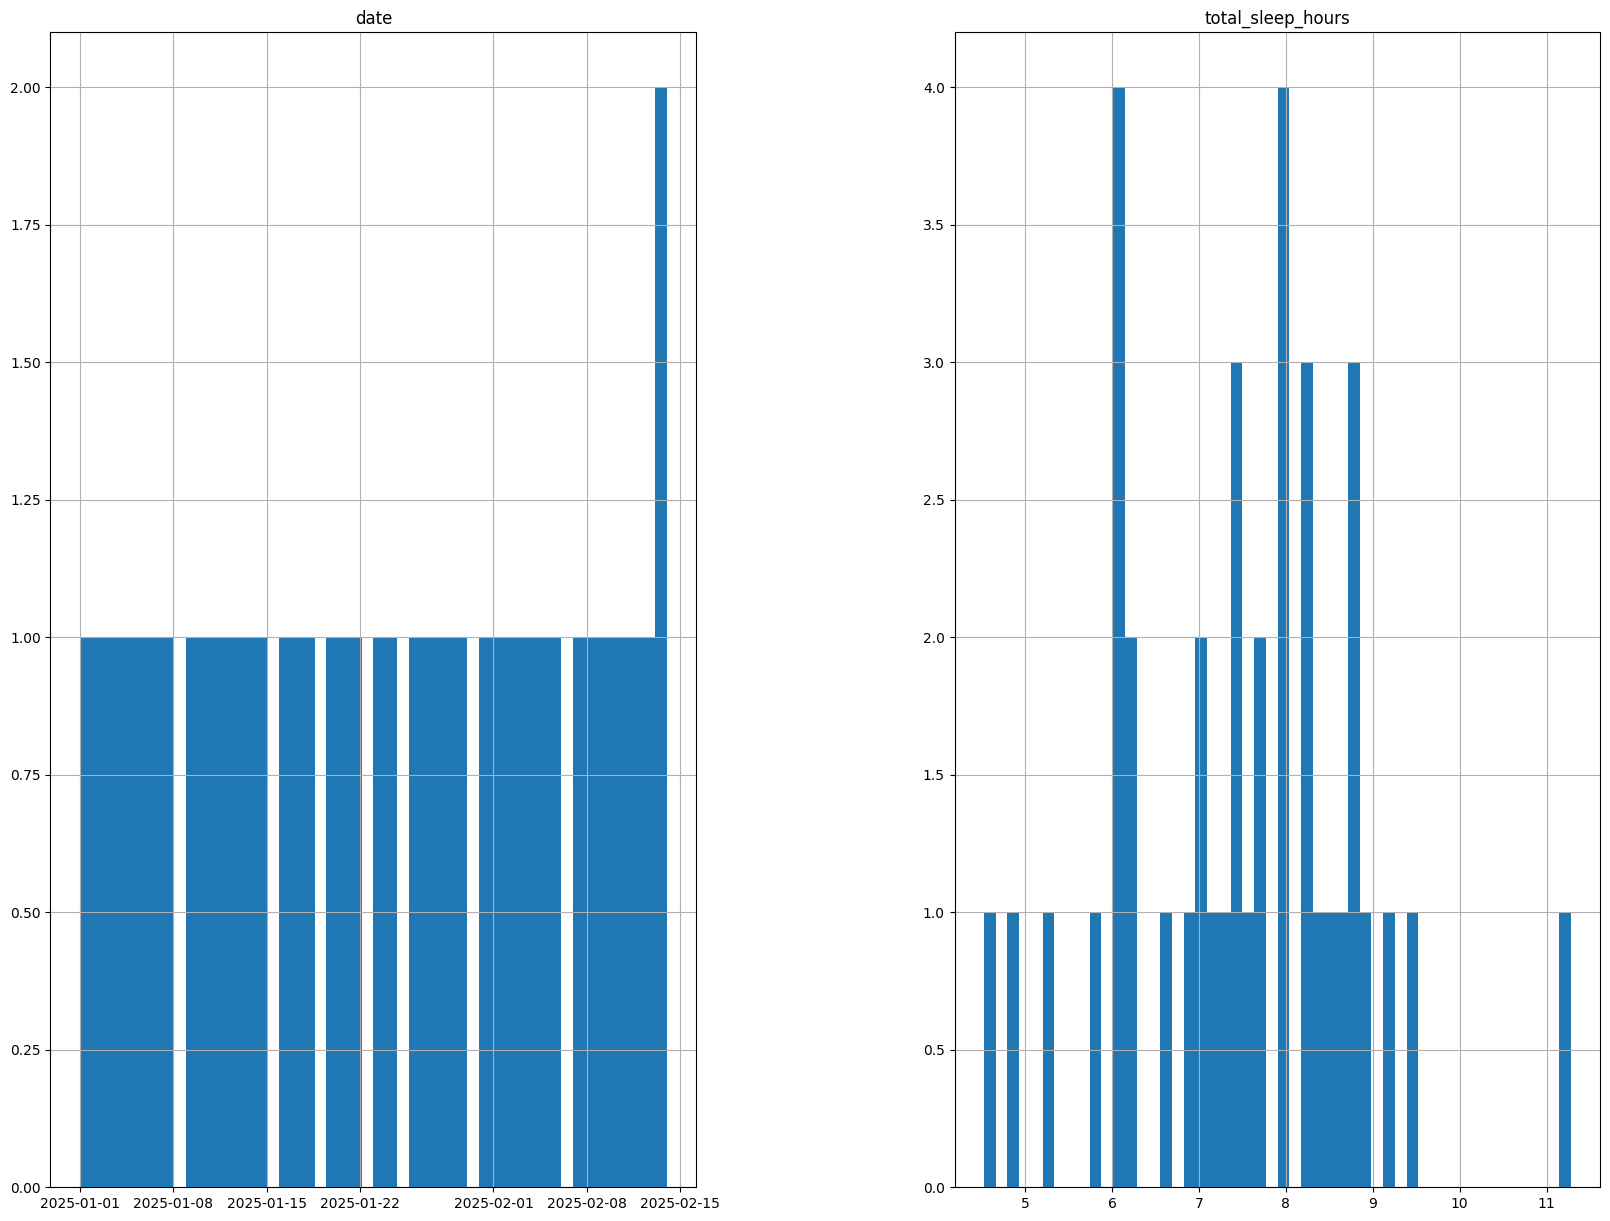

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline
df.hist(bins=50, figsize=(20, 15))
plt.subplots_adjust(wspace=0.4,hspace=0.6)
plt.show()